# Wavelet Threshold denoising 

Testing code for denoising using a hard threshold applied to decomposition levels of a discrete wavelet transform : https://www.kaggle.com/theoviel/denoising-with-direct-wavelet-transform

## Libraries, data and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from datetime import datetime, timedelta
import pywt
import matrixprofile as mp
from matrixprofile.preprocess import preprocess
from sklearn.metrics import mean_squared_error
import warnings
import math

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
##Load data 


Sample_rate = '1T' #1 minutes resampel resolution

df = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\min,max,average gas 11-26 to 01-26 QUERY 2.csv', header=0)

#get block timestamp as datetime, sort by date
df['block_timestamp'] = pd.to_datetime(df['block_timestamp'], format = '%Y-%m-%d %H:%M:%S UTC')
df = df.sort_values(by='block_timestamp',ascending=False)

#convert gas price from wei to giga-wei
df['min_gas_price'] = df['min_gas_price'].apply(lambda x: x/1000000000) 
df['avg_gas_price'] = df['avg_gas_price'].apply(lambda x: x/1000000000)
df['max_gas_price'] = df['max_gas_price'].apply(lambda x: x/1000000000)

#set index to date, resample, fill na
df = df.set_index('block_timestamp')
df = df.squeeze()
df = df.astype('float')
df = df.resample(Sample_rate).mean()
df['block_timestamp'] = df.index
df = df.fillna(method='ffill')


In [4]:
df_week = df.loc['2022-01-5':'2022-01-12']
df_week.head()

,avg_gas_price,max_gas_price,min_gas_price,block_timestamp
block_timestamp,,,,
2022-01-05 00:00:00,139.8570,489.0000,128.8190,2022-01-05 00:00:00
2022-01-05 00:01:00,158.5910,489.0000,146.4040,2022-01-05 00:01:00
2022-01-05 00:02:00,178.4852,750.5224,160.2144,2022-01-05 00:02:00
2022-01-05 00:03:00,172.7522,586.4978,157.3902,2022-01-05 00:03:00
2022-01-05 00:04:00,172.8340,412.8520,155.9510,2022-01-05 00:04:00


In [5]:
# get first week of data
df_week = df.loc['2021-12-5':'2021-12-28']
np_min = df_week['min_gas_price'].to_numpy()
df_week_min = pd.DataFrame(np_min, columns = ['min_gas_price'])


In [6]:
# set our signal to minmum gas price
time = df_week['block_timestamp'].values
signal = df_week_min['min_gas_price'].values

34560

In [7]:
#get mean absolute deviation of signal

def madev(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)



In [8]:
#perform discrete wavelet decompostion on signal, threshold decompostion level, reconstruct signal from thresholded levels 
#tmod can be used to vary level of the threshold
def wavelet_denoising(x, wavelet='db4', level=2, tmod=1):
    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/tmod) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(3 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')



In [9]:

#get signal to noise ratio
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

# Get root mean squared error
def rootmeansqerror (y_actual, y_predicted):
    MSE=mean_squared_error(y_actual, y_predicted)
    return math.sqrt(MSE)



In [10]:
# get list of discret waveelts in pywavelets library
wavelist = pywt.wavelist(kind='discrete')


#given a decompostion level and threshold modifier, return list of all wavelets sorted by SNR, and lsit of all wavelet sorted by RMSE
def snr_rmse_eval(signal, level=1, tmod=1):
    results = []
    for i in wavelist:
        results.append(wavelet_denoising(signal, wavelet=i, level=level, tmod=tmod))    
    SNR = []
    for a in results:
        SNR.append(signaltonoise(a))
    RMSE = []
    for a in results:
        RMSE.append(rootmeansqerror(a, signal))
    
    SNR_RMSE = pd.DataFrame({'SNR':SNR, 'RMSE':RMSE, 'wavelist':wavelist})
    SNR_sort = SNR_RMSE.sort_values(by=['SNR'], ascending=False)
    RMSE_sort = SNR_RMSE.sort_values(by=['RMSE'], ascending=True)
    return SNR_sort, RMSE_sort

In [11]:
#return SNR/RMSE of top 5 wavelets by these metrics, at a given decomposition level and given threshold modifiers
#allows uis to evaluate threshold modifier effect on denoising
def tmod_eval(signal, tmods,level=1 ):
    snr_tmod_eval = [] #each element in this aray, will correspond to a tmod
                       #SNR/RMSE average for the top 5 wavelets by RMSE will be displayed
    for i in tmods:
        snr_signal, rmse_signal = snr_rmse_eval(signal, level=level, tmod=i)
        snr_tmod_eval.append(snr_signal.head().mean().values.tolist())
        
    rmse_tmod_eval = [] #each element in this aray, will correspond to a tmod
                       #SNR/RMSE average for the top 5 wavelets by SNR will be displayed
    for i in tmods:
        snr_signal, rmse_signal = snr_rmse_eval(signal, level=level, tmod=i)
        rmse_tmod_eval.append(rmse_signal.head().mean().values.tolist())
    
    
    snr_rmse_tmod = pd.DataFrame({'SNR,RMSE by SNR':snr_tmod_eval, 'SNR,RMSE by RMSE':rmse_tmod_eval, 'tmod':tmods})

    return  snr_rmse_tmod


## SNR/RMSE eval

In [14]:
#tmod=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4]
#tmod = [0.05, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.25, 0.5, 1, 1.5]
#tmod = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
tmods= [1, 5, 7.5, 10, 12.5, 15, 20]
level = 2
frame = tmod_eval(signal, tmods,level=level )
Split_by_SNR = pd.DataFrame(frame['SNR,RMSE by SNR'].to_list(), columns=['SNR by SNR','RMSE by SNR'])
Split_by_RMSE = pd.DataFrame(frame['SNR,RMSE by RMSE'].to_list(), columns=['SNR by RMSE','RMSE by RMSE'])
tmod_df = (Split_by_SNR).join(Split_by_RMSE).join(frame['tmod'])
tmod_df

,SNR by SNR,RMSE by SNR,SNR by RMSE,RMSE by RMSE,tmod
0,1.831034,9.964134,1.817686,8.859293,1.0
1,1.788759,3.705051,1.787355,3.297046,5.0
2,1.785741,2.930900,1.784347,2.112454,7.5
3,1.784326,2.393883,1.783253,1.476710,10.0
4,1.783552,1.894263,1.782773,1.094407,12.5
5,1.783063,1.543664,1.782544,0.851577,15.0
6,1.782618,1.080187,1.782349,0.563594,20.0


This dataframe contains, for a range of threshold modifiers: 
* average SNR of the top 5 wavelets by SNR
* average RMSE of the top 5 wavelets by SNR
* average SNR of the top 5 wavelets by RMSE
* average SNR of the top 5 wavelets by SNR

('SNR by RMSE', 'SNR by SNR')

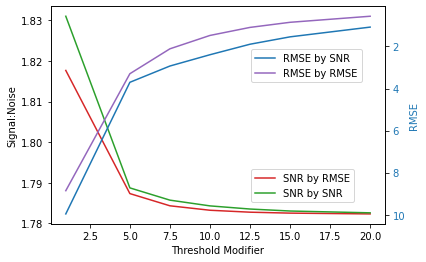

In [15]:
color = 'tab:red'
fig, ax1 = plt.subplots()
ax1.set_xlabel('Threshold Modifier')
ax1.set_ylabel('Signal:Noise')
ax1.plot(tmod_df['tmod'], tmod_df['SNR by RMSE'], color=color)
ax1.plot(tmod_df['tmod'], tmod_df['SNR by SNR'], color='tab:green')
ax1.legend(['SNR by RMSE', 'SNR by SNR'], prop={'size': 10}, loc=[0.6, 0.1])

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('RMSE', color=color)  # we already handled the x-label with ax1
ax2.invert_yaxis()
ax2.plot(tmod_df['tmod'], tmod_df['RMSE by SNR'], color=color)
ax2.plot(tmod_df['tmod'], tmod_df['RMSE by RMSE'], color='tab:purple')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['RMSE by SNR','RMSE by RMSE'], prop={'size': 10}, loc=[0.6, 0.65])


'SNR by RMSE', 'SNR by SNR',


In [17]:
pd.options.display.max_rows = 5
by_SNR, by_RMSE = snr_rmse_eval(signal, level=2, tmod=10)
print(by_SNR)
print(by_RMSE)

                   SNR      RMSE wavelist
8    1.784381989607079  2.372436  bior3.3
10  1.7843710341231627  2.321276  bior3.7
..                 ...       ...      ...
79  1.7696926314946373  5.708314  rbio3.1
70  1.7639659892275183  1.638929     dmey

[106 rows x 3 columns]
                   SNR      RMSE wavelist
13  1.7831437038639362  1.417564  bior5.5
74  1.7832091579393041  1.467311  rbio1.5
..                 ...       ...      ...
7   1.7842284138684805  2.616192  bior3.1
79  1.7696926314946373  5.708314  rbio3.1

[106 rows x 3 columns]


In [21]:
pd.options.display.max_rows = 20

by_SNR, by_RMSE = snr_rmse_eval(signal, level=2, tmod=3)
print(by_SNR)
print(by_RMSE)

                   SNR       RMSE wavelist
0   1.7976726064995459   5.687339  bior1.1
72  1.7976726064995459   5.687339  rbio1.1
32  1.7976726064995459   5.687339      db1
71  1.7976726064995459   5.687339     haar
15  1.7955138336731975   5.280412    coif1
..                 ...        ...      ...
82   1.785298722489693   6.530484  rbio3.7
81  1.7830199571543175   6.948376  rbio3.5
70  1.7747931467710911   5.091142     dmey
80    1.77403051979918   8.387953  rbio3.3
79    1.58426247921981  23.827100  rbio3.1

[106 rows x 3 columns]
                    SNR       RMSE wavelist
104   1.794067327935234   4.988308    sym19
100   1.794137837919836   5.002985    sym15
96   1.7941476204624338   5.004629    sym11
94   1.7941459301018137   5.004638     sym9
92    1.794183715583086   5.008748     sym7
..                  ...        ...      ...
83   1.7859980674708604   6.422412  rbio3.9
82    1.785298722489693   6.530484  rbio3.7
81   1.7830199571543175   6.948376  rbio3.5
80     1.77403051979

In [24]:
by_SNR[:30]


,SNR,RMSE,wavelist
0,1.7976726064995459,5.687339,bior1.1
72,1.7976726064995459,5.687339,rbio1.1
32,1.7976726064995459,5.687339,db1
71,1.7976726064995459,5.687339,haar
15,1.7955138336731975,5.280412,coif1
...,...,...,...
51,1.7948980796417262,5.158177,db20
52,1.7948829749256152,5.160428,db21
59,1.7948590332144894,5.150785,db28
3,1.7948454448390294,5.158050,bior2.2


# Visualisation

## Original Time Series

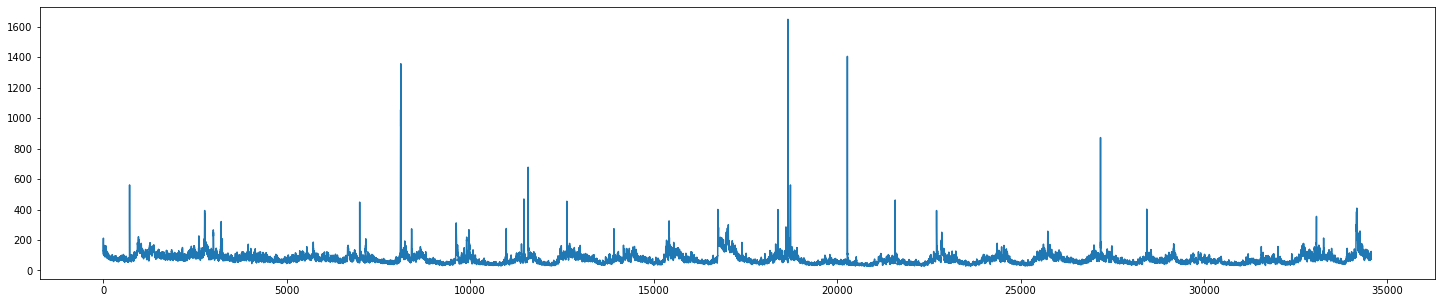

In [26]:
figure(figsize=(25,5))

x_coordinate = [ i for i in range(len(signal)) ]
fig = plt.plot(x_coordinate,signal)

plt.show()

In [28]:
from sklearn.metrics import mean_absolute_percentage_error

## DB32 Denoised

1.8823090935742406
13.935427086124799
0.1358875489783173


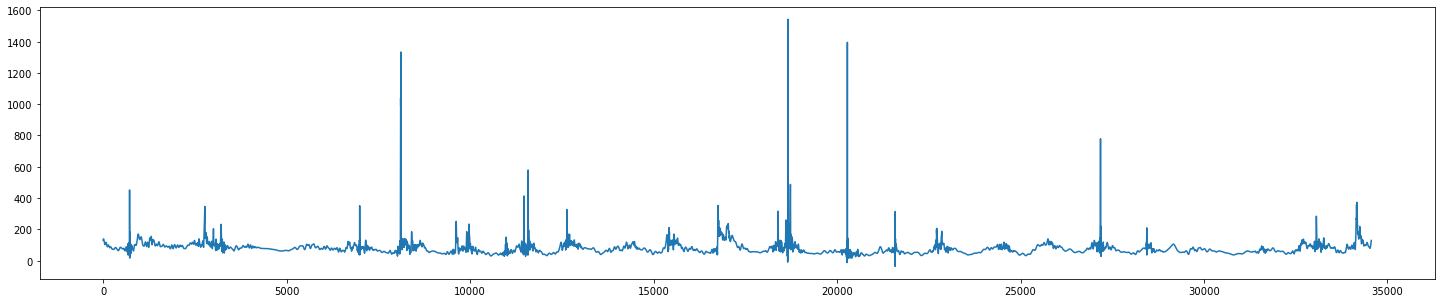

In [30]:
db32_L2_tmod0_5 = wavelet_denoising(signal, wavelet='db32', level=2, tmod=0.5)
print(signaltonoise(db32_L2_tmod0_5, axis=0, ddof=0))
print(rootmeansqerror (signal, db32_L2_tmod0_5))
print(mean_absolute_percentage_error (signal, db32_L2_tmod0_5))
figure(figsize=(25,5))

x_coordinate = [ i for i in range(len(db32_L2_tmod0_5))]
fig = plt.plot(x_coordinate,db32_L2_tmod0_5)

plt.show()

## Biorthogonal Wavelet denoised

1.8591634179013288
12.87841596200728
0.12978892341291615


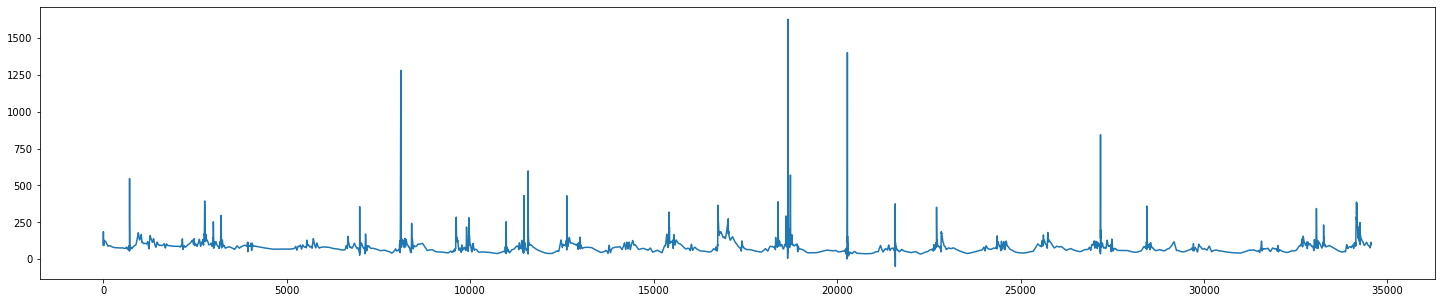

In [37]:
rbio5_5_L2tmod0_4 = wavelet_denoising(signal, wavelet='rbio5.5', level=2, tmod=0.4)
filtered = rbio5_5_L2tmod0_4
print(signaltonoise(filtered, axis=0, ddof=0))
print(rootmeansqerror (signal, filtered))
print(mean_absolute_percentage_error (signal, filtered))
figure(figsize=(25,5))

x_coordinate = [ i for i in range(len(filtered))]
fig = plt.plot(x_coordinate,filtered)

plt.show()

We can see that varying level of threshold modifier yeilds similar results;

There is little difference between high level low tmod, vs low level high tmod

So we must only select the right wavelet, then optimize for our two metrics


## Matrix Profiles of original and denoised time series

In [434]:
import matrixprofile as mp
from matrixprofile.visualize import plot_snippets

D:\Anaconda\lib\site-packages\matrixprofile\visualize.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


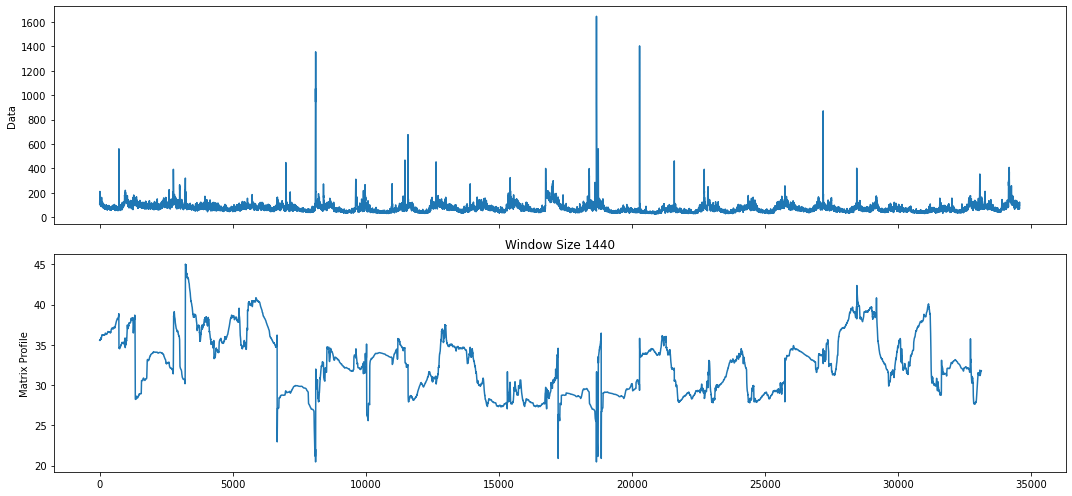

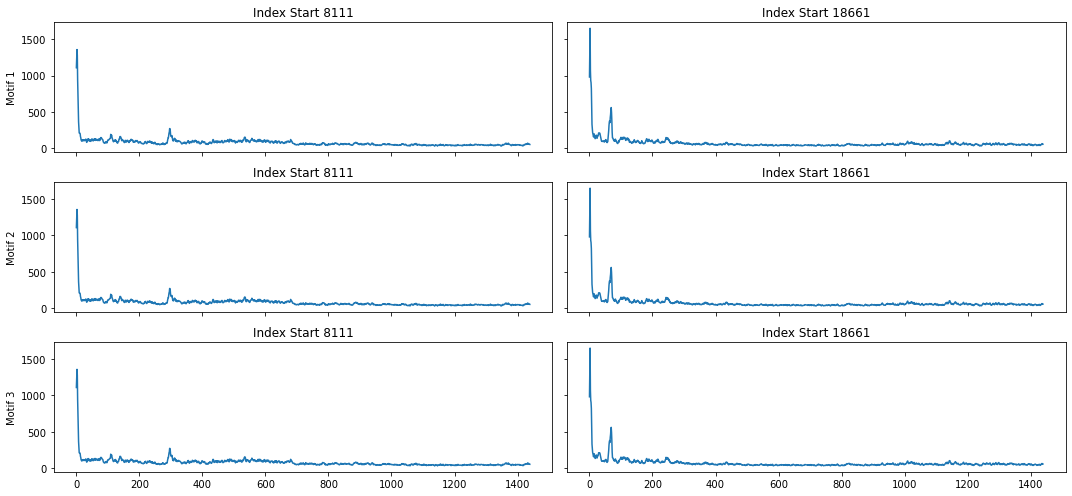

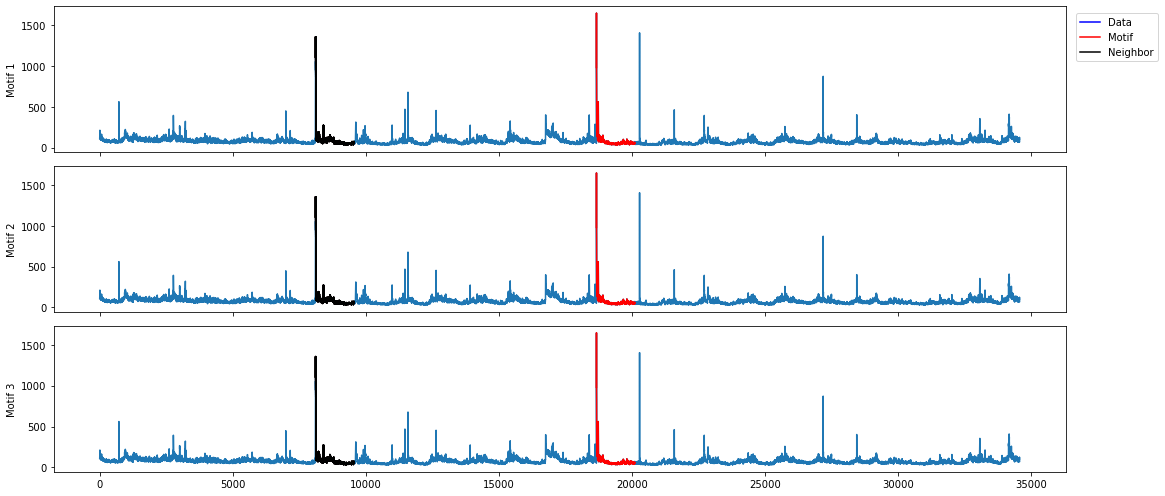

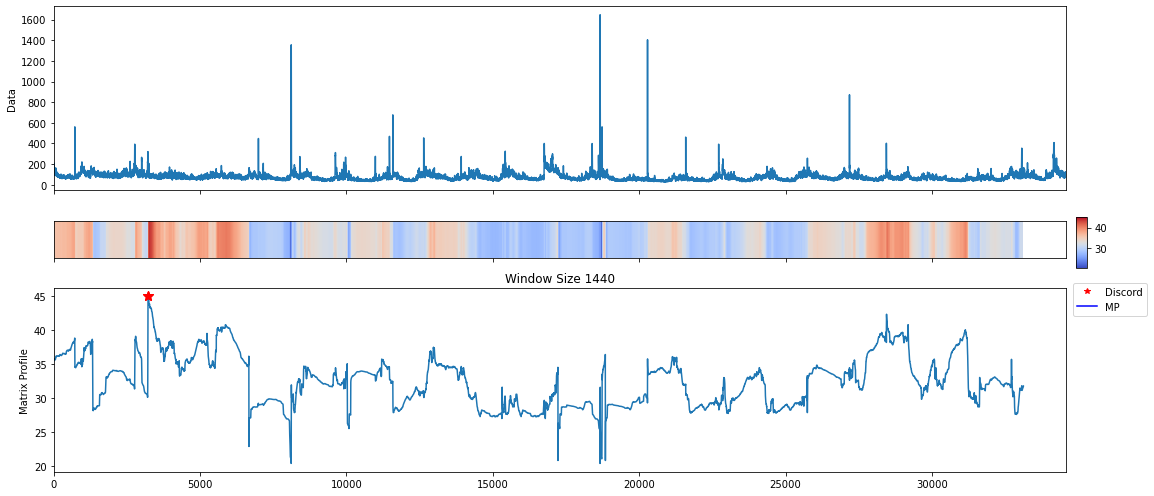

In [436]:
mp_profile, mp_figures = mp.analyze(signal, windows=1440, threshold=0.9)

D:\Anaconda\lib\site-packages\matrixprofile\visualize.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


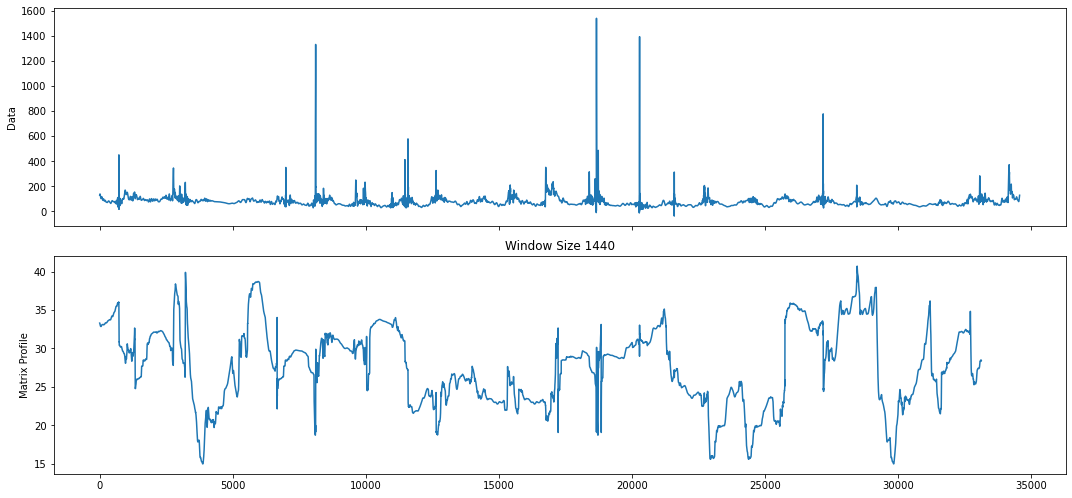

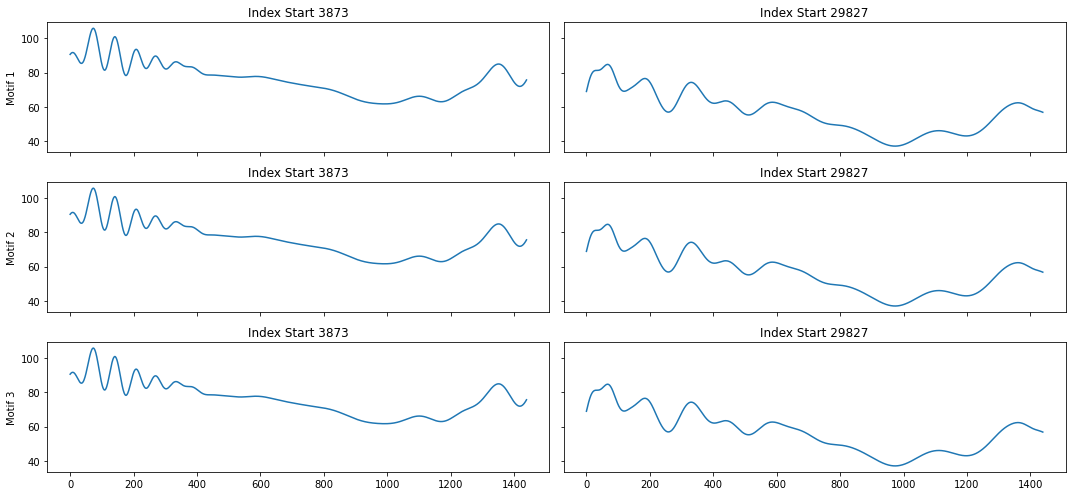

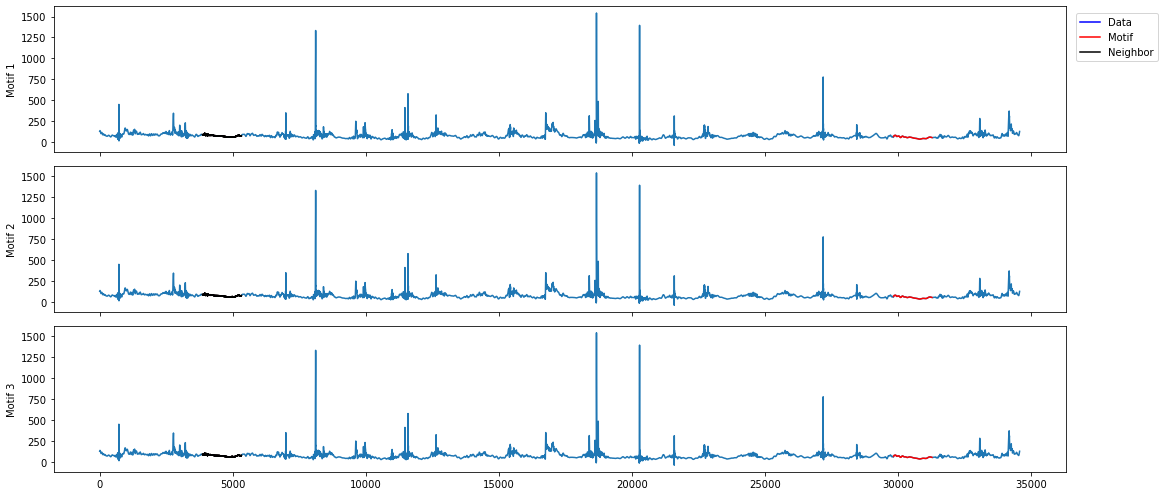

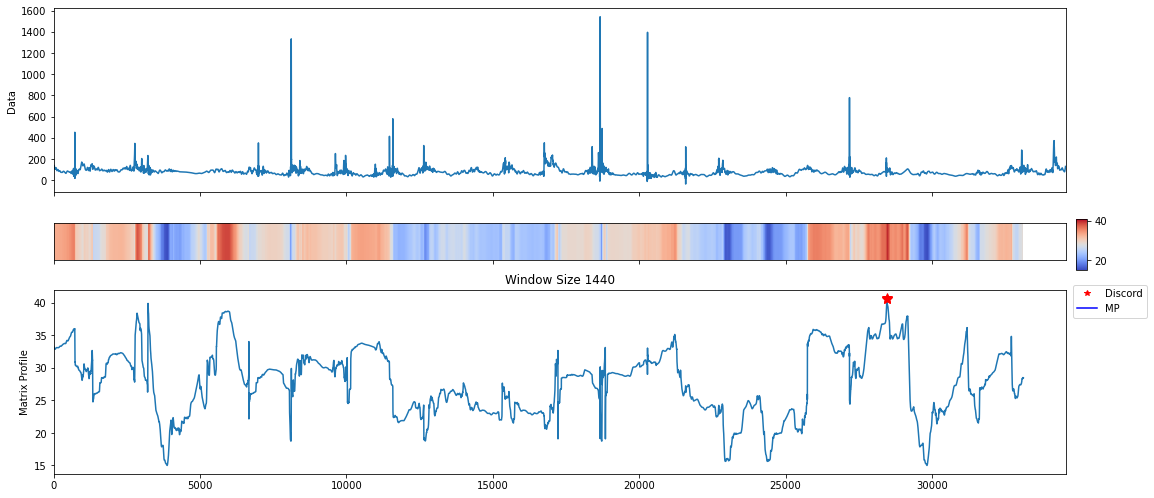

In [438]:
mp_profile, mp_figures = mp.analyze(db32_L2_tmod0_5, windows=1440, threshold=0.9)


D:\Anaconda\lib\site-packages\matrixprofile\visualize.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


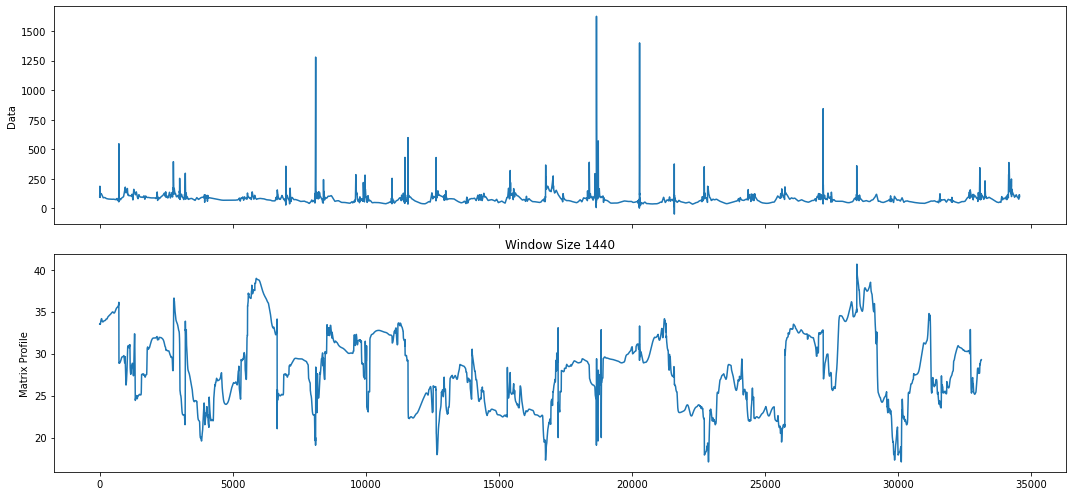

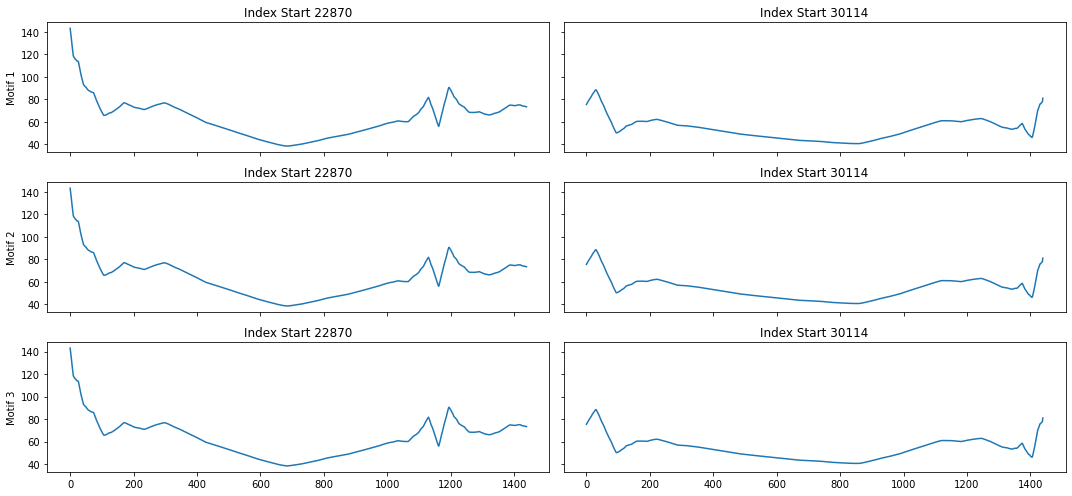

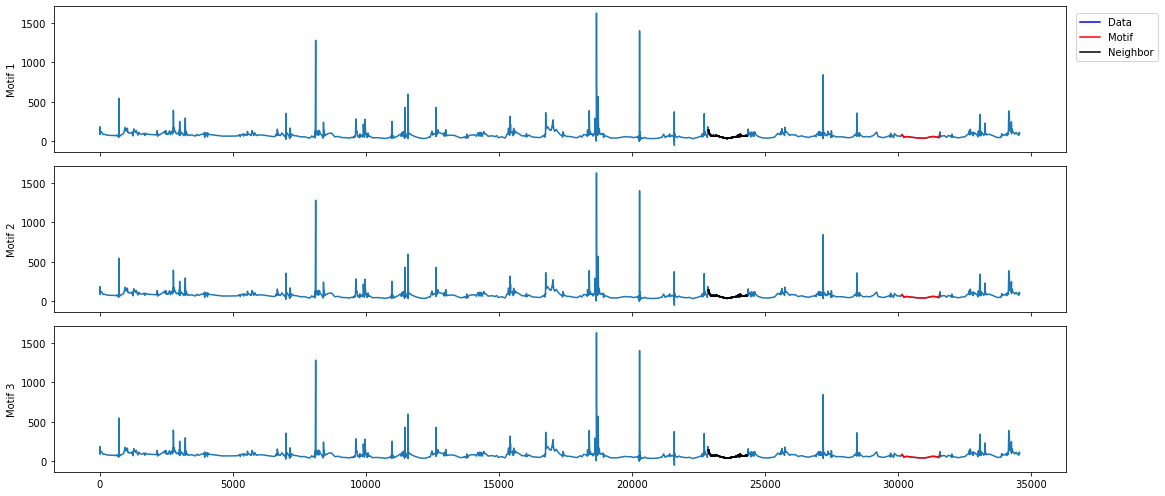

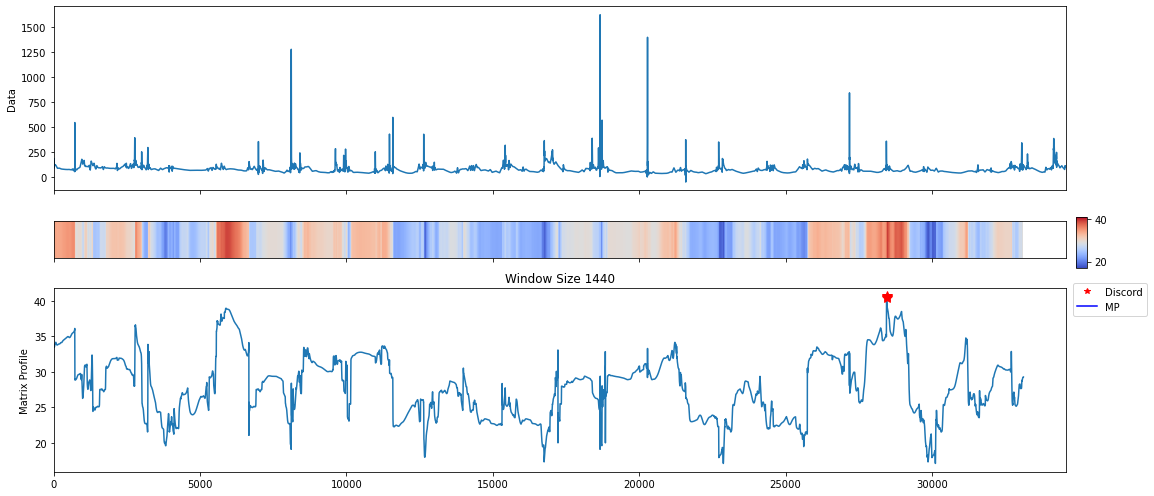

In [437]:
mp_profile, mp_figures = mp.analyze(rbio5_5_L2tmod0_4, windows=1440, threshold=0.9)

We can see that varying level of threshold modifier yeilds similar results;

There is little difference between high level low tmod, vs low level high tmod

So we must only select the right wavelet, then optimize for our two metrics
